# Restaurant Rating Prediction

Terdapat 3 struktur skenario:

- Skenario 1 (menggunakan model TF-IDF):
    - SVM
    - Naive Bayes
    - Logistic Regression
- Skenario 2 (menggunakan transformers):
    - BERT
    - DistillBERT
- Skenario 3 (melakukan augmentasi menggunakan 4 augmentasi (EDA, Modified EDA, BERT))
    - SVM (EDA, Modified EDA, BERT)
    - Naive Bayes (EDA, Modified EDA, BERT)
    - Logistic Regression (EDA, Modified EDA, BERT)
    - BERT (EDA, Modified EDA, BERT)
    - DistillBERT (EDA, Modified EDA, BERT)

## Import Library

In [55]:
## 0. Setup & Library

!pip -q install pandas numpy scikit-learn matplotlib nltk tqdm
!pip -q install torch transformers datasets accelerate
!pip -q install nlpaug

import os, re, glob, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.utils.class_weight import compute_class_weight

import torch

# Reduce TensorFlow/Flax side-effects in Colab
os.environ["TRANSFORMERS_NO_TF"] = "1"
os.environ["TRANSFORMERS_NO_FLAX"] = "1"

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

HAS_GPU = torch.cuda.is_available()
DEVICE = "cuda" if HAS_GPU else "cpu"
print("Device:", DEVICE)
if HAS_GPU:
    print("GPU:", torch.cuda.get_device_name(0))


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Device: cuda
GPU: Tesla T4


## Load Dataset

In [56]:
DATA_PATH = "/kaggle/input/google-maps-restaurant-reviews/reviews.csv"  # <-- ganti sesuai file Anda

if not os.path.exists(DATA_PATH):
    candidates = glob.glob("**/*.csv", recursive=True)
    preferred = [c for c in candidates if re.search(r"(review|google|maps|restaurant)", c, re.I)]
    if preferred:
        DATA_PATH = preferred[0]
    elif candidates:
        DATA_PATH = candidates[0]

print("Using DATA_PATH:", DATA_PATH)

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
df.head()


Using DATA_PATH: /kaggle/input/google-maps-restaurant-reviews/reviews.csv
Shape: (1100, 6)


,business_name,author_name,text,photo,rating,rating_category
0,Haci'nin Yeri - Yigit Lokantasi,Gulsum Akar,We went to Marmaris with my wife for a holiday...,dataset/taste/hacinin_yeri_gulsum_akar.png,5,taste
1,Haci'nin Yeri - Yigit Lokantasi,Oguzhan Cetin,During my holiday in Marmaris we ate here to f...,dataset/menu/hacinin_yeri_oguzhan_cetin.png,4,menu
2,Haci'nin Yeri - Yigit Lokantasi,Yasin Kuyu,Prices are very affordable. The menu in the ph...,dataset/outdoor_atmosphere/hacinin_yeri_yasin_...,3,outdoor_atmosphere
3,Haci'nin Yeri - Yigit Lokantasi,Orhan Kapu,Turkey's cheapest artisan restaurant and its f...,dataset/indoor_atmosphere/hacinin_yeri_orhan_k...,5,indoor_atmosphere
4,Haci'nin Yeri - Yigit Lokantasi,Ozgur Sati,I don't know what you will look for in terms o...,dataset/menu/hacinin_yeri_ozgur_sati.png,3,menu


## Exploratory Data Analysis 

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   business_name    1100 non-null   object
 1   author_name      1100 non-null   object
 2   text             1100 non-null   object
 3   photo            1100 non-null   object
 4   rating           1100 non-null   int64 
 5   rating_category  1100 non-null   object
dtypes: int64(1), object(5)
memory usage: 51.7+ KB


In [58]:
rating_counts = df["rating"].value_counts().sort_index()
rating_counts

rating
1     80
2     72
3    172
4    316
5    460
Name: count, dtype: int64

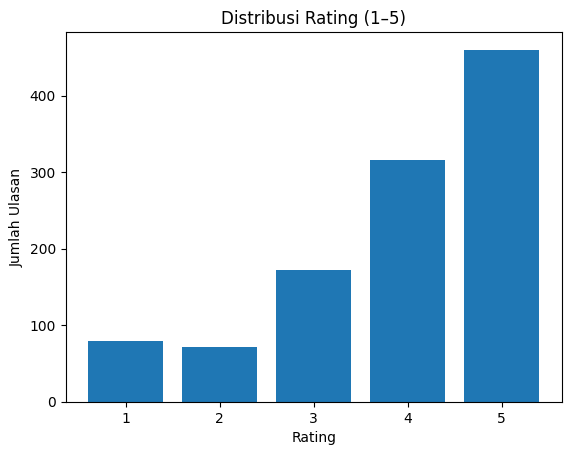

In [59]:
plt.figure()
plt.bar(rating_counts.index.astype(str), rating_counts.values)
plt.title("Distribusi Rating (1–5)")
plt.xlabel("Rating")
plt.ylabel("Jumlah Ulasan")
plt.show()

In [60]:
df["char_len"] = df["text"].str.len()
df["word_len"] = df["text"].str.split().apply(len)
df[["char_len", "word_len"]].describe()

,char_len,word_len
count,1100.000000,1100.000000
mean,110.835455,20.051818
std,69.153870,12.977619
min,5.000000,1.000000
25%,62.000000,11.000000
50%,104.000000,19.000000
75%,147.000000,27.000000
max,914.000000,179.000000


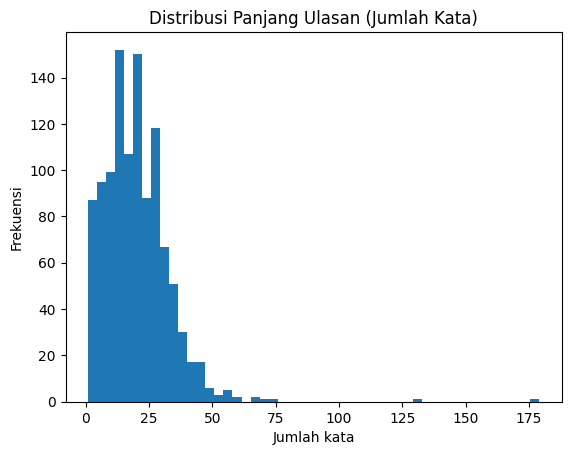

In [61]:
plt.figure()
plt.hist(df["word_len"], bins=50)
plt.title("Distribusi Panjang Ulasan (Jumlah Kata)")
plt.xlabel("Jumlah kata")
plt.ylabel("Frekuensi")
plt.show()

 TAMBAHIN WORDCLOUDDD

## Preprocessing

In [62]:
import nltk

resources = [
    ("tokenizers/punkt", "punkt"),
    ("taggers/averaged_perceptron_tagger", "averaged_perceptron_tagger"),
    ("taggers/averaged_perceptron_tagger_eng", "averaged_perceptron_tagger_eng"),
    ("corpora/wordnet", "wordnet"),
    ("corpora/omw-1.4", "omw-1.4"),
]

for path, name in resources:
    try:
        nltk.data.find(path)
    except LookupError:
        nltk.download(name)

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet

lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [63]:
def penn_to_wn(tag):
    if tag.startswith("J"): return wordnet.ADJ
    if tag.startswith("V"): return wordnet.VERB
    if tag.startswith("N"): return wordnet.NOUN
    if tag.startswith("R"): return wordnet.ADV
    return wordnet.NOUN

def basic_normalize(text: str) -> str:
    text = str(text).strip()
    text = re.sub(r"\s+", " ", text)
    return text

def clean_for_lemma(text: str) -> str:
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def lemmatize_text(text: str) -> str:
    text = clean_for_lemma(basic_normalize(text))
    if not text:
        return ""
    toks = word_tokenize(text)
    pos_tags = nltk.pos_tag(toks)
    lemmas = [lemmatizer.lemmatize(w, penn_to_wn(t)) for w, t in pos_tags]
    return " ".join(lemmas)

In [64]:
assert "text" in df.columns, "Kolom 'text' tidak ditemukan."
assert "rating" in df.columns, "Kolom 'rating' tidak ditemukan."

df = df.dropna(subset=["text", "rating"]).copy()
df["rating"] = df["rating"].astype(int)
df = df[df["rating"].between(1, 5)]

df["text_basic"] = df["text"].apply(basic_normalize)
df["text_lemma"] = df["text"].apply(lemmatize_text)
df["text_clean"] = df["text_lemma"]

print("After cleaning:", df.shape)
df.head()

After cleaning: (1100, 11)


,business_name,author_name,text,photo,rating,rating_category,char_len,word_len,text_basic,text_lemma,text_clean
0,Haci'nin Yeri - Yigit Lokantasi,Gulsum Akar,We went to Marmaris with my wife for a holiday...,dataset/taste/hacinin_yeri_gulsum_akar.png,5,taste,680,130,We went to Marmaris with my wife for a holiday...,we go to marmaris with my wife for a holiday w...,we go to marmaris with my wife for a holiday w...
1,Haci'nin Yeri - Yigit Lokantasi,Oguzhan Cetin,During my holiday in Marmaris we ate here to f...,dataset/menu/hacinin_yeri_oguzhan_cetin.png,4,menu,914,179,During my holiday in Marmaris we ate here to f...,during my holiday in marmaris we eat here to f...,during my holiday in marmaris we eat here to f...
2,Haci'nin Yeri - Yigit Lokantasi,Yasin Kuyu,Prices are very affordable. The menu in the ph...,dataset/outdoor_atmosphere/hacinin_yeri_yasin_...,3,outdoor_atmosphere,173,31,Prices are very affordable. The menu in the ph...,price be very affordable the menu in the photo...,price be very affordable the menu in the photo...
3,Haci'nin Yeri - Yigit Lokantasi,Orhan Kapu,Turkey's cheapest artisan restaurant and its f...,dataset/indoor_atmosphere/hacinin_yeri_orhan_k...,5,indoor_atmosphere,63,9,Turkey's cheapest artisan restaurant and its f...,turkey s cheap artisan restaurant and it food ...,turkey s cheap artisan restaurant and it food ...
4,Haci'nin Yeri - Yigit Lokantasi,Ozgur Sati,I don't know what you will look for in terms o...,dataset/menu/hacinin_yeri_ozgur_sati.png,3,menu,161,31,I don't know what you will look for in terms o...,i don t know what you will look for in term of...,i don t know what you will look for in term of...


In [65]:
def map_3class(r):
    if r <= 2:
        return 0  # negative
    elif r == 3:
        return 1  # neutral
    else:
        return 2  # positive

df["label3"] = df["rating"].apply(map_3class)
df["label3"].value_counts().sort_index()

label3
0    152
1    172
2    776
Name: count, dtype: int64

In [66]:
X = df["text_clean"].values
y = df["label3"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=SEED,
    stratify=y
)

In [67]:
# X = df["text_clean"].values
# y = df["rating"].values

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y,
#     test_size=0.2,
#     random_state=SEED,
#     stratify=y
# )

# print("Train:", len(X_train), "Test:", len(X_test))
# print("Distribusi Train:", Counter(y_train))
# print("Distribusi Test :", Counter(y_test))


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


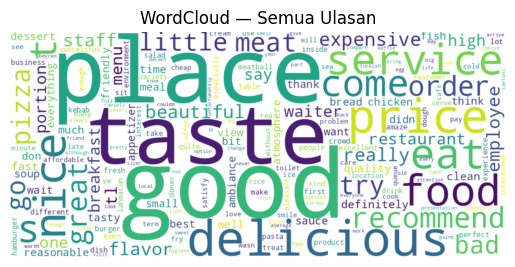

In [68]:
!pip -q install wordcloud

from wordcloud import WordCloud

# Wordcloud semua data
all_text = " ".join(df["text_clean"].astype(str).tolist())

wc = WordCloud(
    width=1100,
    height=500,
    background_color="white",
    collocations=False
).generate(all_text)

plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud — Semua Ulasan")
plt.show()

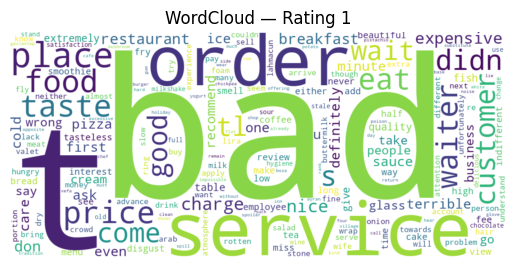

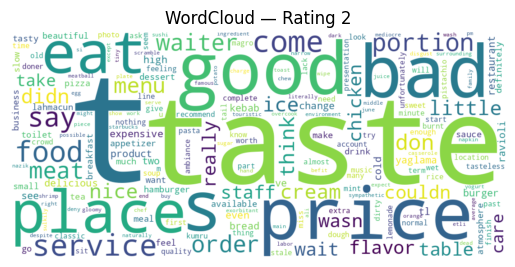

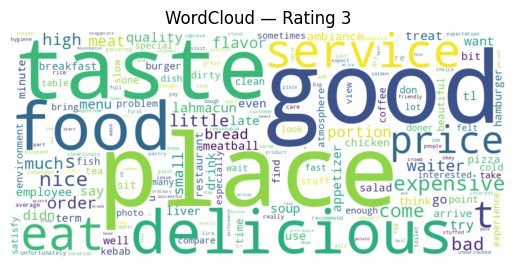

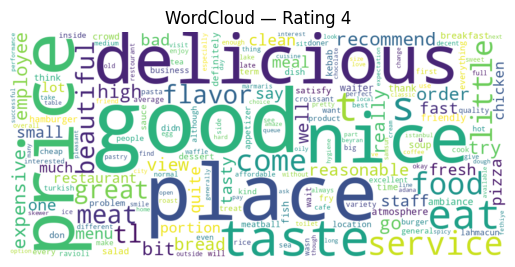

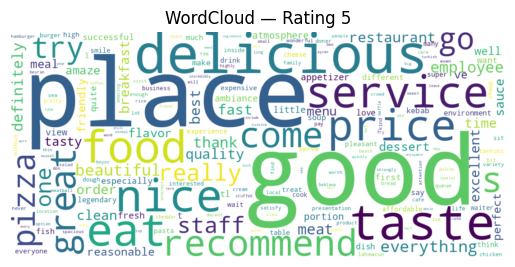

In [69]:
for r in sorted(df["rating"].unique()):
    txt = " ".join(df.loc[df["rating"] == r, "text_clean"].astype(str).tolist())
    if not txt.strip():
        continue
    wc = WordCloud(width=1100, height=500, background_color="white",
                   collocations=False).generate(txt)
    plt.figure()
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud — Rating {r}")
    plt.show()


For model evaluation

In [70]:
LABEL_NAMES_3 = ["neg", "neu", "pos"]

def eval_report(y_true, y_pred, title="Model"):
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average="macro")
    f1w = f1_score(y_true, y_pred, average="weighted")

    print(f"=== {title} ===")
    print("Accuracy :", round(acc, 4))
    print("F1-macro :", round(f1m, 4))
    print("F1-weight:", round(f1w, 4))
    print()
    print(classification_report(
        y_true, y_pred,
        target_names=LABEL_NAMES_3,
        digits=4, zero_division=0
    ))
    print()
    return {"model": title, "accuracy": acc, "f1_macro": f1m, "f1_weighted": f1w}

def plot_confusion(y_true, y_pred, labels=[0,1,2], title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure()
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, LABEL_NAMES_3)
    plt.yticks(tick_marks, LABEL_NAMES_3)
    plt.ylabel("True")
    plt.xlabel("Predicted")
    plt.tight_layout()
    plt.show()

In [71]:
# def eval_report(y_true, y_pred, title="Model"):
#     acc = accuracy_score(y_true, y_pred)
#     f1m = f1_score(y_true, y_pred, average="macro")
#     f1w = f1_score(y_true, y_pred, average="weighted")

#     print(f"=== {title} ===")
#     print("Accuracy :", round(acc, 4))
#     print("F1-macro :", round(f1m, 4))
#     print("F1-weight:", round(f1w, 4))
#     print()
#     print(classification_report(y_true, y_pred, digits=4, zero_division=0))
#     print()
#     return {"model": title, "accuracy": acc, "f1_macro": f1m, "f1_weighted": f1w}

# def plot_confusion(y_true, y_pred, labels=range(1, 6), title="Confusion Matrix"):
#     cm = confusion_matrix(y_true, y_pred, labels=list(labels))
#     plt.figure()
#     plt.imshow(cm, interpolation="nearest")
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(labels))
#     plt.xticks(tick_marks, labels)
#     plt.yticks(tick_marks, labels)
#     plt.ylabel("True")
#     plt.xlabel("Predicted")
#     plt.tight_layout()
#     plt.show()


# Skenario 1

In [72]:
results_s1 = []


In [73]:
# def fit_tfidf(train_texts, test_texts):
#     vec = TfidfVectorizer(lowercase=True, max_features=50000, ngram_range=(1, 2))
#     Xtr = vec.fit_transform(train_texts)
#     Xte = vec.transform(test_texts)
#     return vec, Xtr, Xte

In [74]:
def fit_tfidf(train_texts, test_texts):
    vec = TfidfVectorizer(
        lowercase=True,
        max_features=80000,
        ngram_range=(1,2),
        sublinear_tf=True,
        min_df=2,
        max_df=0.95
    )
    Xtr = vec.fit_transform(train_texts)
    Xte = vec.transform(test_texts)
    return vec, Xtr, Xte

## SVM

In [75]:
def train_eval_svm(train_texts, train_labels, test_texts, test_labels, suffix="", class_weight=None):
    vec, Xtr, Xte = fit_tfidf(train_texts, test_texts)
    svm = LinearSVC(class_weight=class_weight)
    svm.fit(Xtr, train_labels)
    pred = svm.predict(Xte)
    res = eval_report(test_labels, pred, f"Linear SVM{suffix}")
    return res, vec, svm, pred

In [76]:
svm_s1_res, _, _, _ = train_eval_svm(
    X_train, y_train, X_test, y_test,
    suffix=" (S1 baseline)",
    class_weight=None
)
results_s1.append(svm_s1_res)

=== Linear SVM (S1 baseline) ===
Accuracy : 0.7182
F1-macro : 0.4257
F1-weight: 0.6672

              precision    recall  f1-score   support

         neg     0.3529    0.1935    0.2500        31
         neu     0.2857    0.1176    0.1667        34
         pos     0.7831    0.9548    0.8605       155

    accuracy                         0.7182       220
   macro avg     0.4739    0.4220    0.4257       220
weighted avg     0.6456    0.7182    0.6672       220




## Naive Bayes

In [77]:
def train_eval_nb(train_texts, train_labels, test_texts, test_labels, suffix=""):
    vec, Xtr, Xte = fit_tfidf(train_texts, test_texts)
    nb = MultinomialNB()
    nb.fit(Xtr, train_labels)
    pred = nb.predict(Xte)
    res = eval_report(test_labels, pred, f"Naive Bayes{suffix}")
    return res, vec, nb, pred

In [78]:
nb_s1_res, _, _, _ = train_eval_nb(
    X_train, y_train, X_test, y_test,
    suffix=" (S1 baseline)"
)
results_s1.append(nb_s1_res)

=== Naive Bayes (S1 baseline) ===
Accuracy : 0.7045
F1-macro : 0.2756
F1-weight: 0.5824

              precision    recall  f1-score   support

         neg     0.0000    0.0000    0.0000        31
         neu     0.0000    0.0000    0.0000        34
         pos     0.7045    1.0000    0.8267       155

    accuracy                         0.7045       220
   macro avg     0.2348    0.3333    0.2756       220
weighted avg     0.4964    0.7045    0.5824       220




## Logistic Refression

In [79]:
from sklearn.linear_model import LogisticRegression

def train_eval_lr(train_texts, train_labels, test_texts, test_labels, suffix="", class_weight=None):
    vec, Xtr, Xte = fit_tfidf(train_texts, test_texts)

    lr = LogisticRegression(
        max_iter=2000,
        class_weight=class_weight,
        n_jobs=None,        # biar aman di Windows
        solver="saga",      # robust utk sparse + multiclass
        multi_class="multinomial"
    )

    lr.fit(Xtr, train_labels)
    pred = lr.predict(Xte)
    res = eval_report(test_labels, pred, f"Logistic Regression{suffix}")
    return res, vec, lr, pred


In [80]:
lr_s1_res, _, _, _ = train_eval_lr(
    X_train, y_train, X_test, y_test,
    suffix=" (S1 baseline)",
    class_weight=None
)
results_s1.append(lr_s1_res)

=== Logistic Regression (S1 baseline) ===
Accuracy : 0.7136
F1-macro : 0.3334
F1-weight: 0.6141

              precision    recall  f1-score   support

         neg     0.5000    0.0323    0.0606        31
         neu     0.4000    0.0588    0.1026        34
         pos     0.7230    0.9935    0.8370       155

    accuracy                         0.7136       220
   macro avg     0.5410    0.3615    0.3334       220
weighted avg     0.6417    0.7136    0.6141       220




## Recap

In [81]:
from IPython.display import display
import pandas as pd

s1_table = pd.DataFrame(results_s1)

s1_best = (
    s1_table
    .sort_values("f1_macro", ascending=False)
    .drop_duplicates(subset=["model"], keep="first")
    .reset_index(drop=True)
)

display(s1_best)


,model,accuracy,f1_macro,f1_weighted
0,Linear SVM (S1 baseline),0.718182,0.425711,0.667222
1,Logistic Regression (S1 baseline),0.713636,0.333376,0.614065
2,Naive Bayes (S1 baseline),0.704545,0.275556,0.582424


# Skenario 2

In [82]:
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback
DEFAULT_MAX_LEN = 256 if HAS_GPU else 128
DEFAULT_BATCH = 8 if HAS_GPU else 2
DEFAULT_EPOCHS = 100

USE_SMALL_TRAIN_IF_CPU = True
SMALL_TRAIN_N = 2000

def make_hf_dataset(texts, labels):
    return Dataset.from_dict({"text": list(texts), "label": [int(l) for l in labels]})

# def make_hf_dataset(texts, labels):
#     return Dataset.from_dict({"text": list(texts), "label": [int(l) - 1 for l in labels]})

def make_tokenize_fn(tokenizer, max_length):
    def _tok(batch):
        return tokenizer(batch["text"], truncation=True, padding="max_length", max_length=max_length)
    return _tok

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, preds)
    f1m = f1_score(labels, preds, average="macro")
    f1w = f1_score(labels, preds, average="weighted")
    return {"accuracy": acc, "f1_macro": f1m, "f1_weighted": f1w}

def maybe_shrink_train(train_texts, train_labels):
    if (not HAS_GPU) and USE_SMALL_TRAIN_IF_CPU and len(train_texts) > SMALL_TRAIN_N:
        return train_texts[:SMALL_TRAIN_N], train_labels[:SMALL_TRAIN_N]
    return train_texts, train_labels

def build_training_args(out_dir, epochs, batch_size):
    common = dict(
        output_dir=out_dir,
        save_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        weight_decay=0.01,
        logging_steps=50,
        report_to="none",
        seed=SEED,
        fp16=HAS_GPU,
        dataloader_num_workers=0,

        evaluation_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro",
        greater_is_better=True,
    )
    try:
        return TrainingArguments(**common)
    except TypeError:
        common.pop("evaluation_strategy", None)
        common["eval_strategy"] = "epoch"
        return TrainingArguments(**common)


class WeightedTrainer(Trainer):
    def __init__(self, class_weights=None, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.class_weights = class_weights

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        inputs = dict(inputs)
        labels = inputs.get("labels")

        outputs = model(**inputs)
        logits = outputs.get("logits")

        base_model = model.module if hasattr(model, "module") else model
        num_labels = base_model.config.num_labels

        if self.class_weights is not None:
            cw = self.class_weights.to(logits.device)
            loss_fct = torch.nn.CrossEntropyLoss(weight=cw)
        else:
            loss_fct = torch.nn.CrossEntropyLoss()

        loss = loss_fct(logits.view(-1, num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss


def _build_trainer(model, args, train_tok, test_tok, tokenizer, use_class_weights, class_weights):
    base_kwargs = dict(
        model=model,
        args=args,
        train_dataset=train_tok,
        eval_dataset=test_tok,
        compute_metrics=compute_metrics,
    )

    if use_class_weights:
        cls = WeightedTrainer
        base_kwargs["class_weights"] = class_weights
    else:
        cls = Trainer

    callbacks = [EarlyStoppingCallback(early_stopping_patience=1)]

    try:
        return cls(**base_kwargs, tokenizer=tokenizer, callbacks=callbacks)
    except TypeError:
        return cls(**base_kwargs, processing_class=tokenizer, callbacks=callbacks)

def safe_load_sequence_classifier(model_name, num_labels=3):
    try:
        return AutoModelForSequenceClassification.from_pretrained(
            model_name, num_labels=num_labels, use_safetensors=False
        )
    except TypeError:
        return AutoModelForSequenceClassification.from_pretrained(
            model_name, num_labels=num_labels
        )


# def safe_load_sequence_classifier(model_name, num_labels=5):
#     try:
#         return AutoModelForSequenceClassification.from_pretrained(
#             model_name, num_labels=num_labels, use_safetensors=False
#         )
#     except TypeError:
#         return AutoModelForSequenceClassification.from_pretrained(
#             model_name, num_labels=num_labels
#         )

def train_eval_transformer(
    model_name,
    train_texts, train_labels,
    test_texts, test_labels,
    epochs=DEFAULT_EPOCHS, batch_size=DEFAULT_BATCH,
    max_length=DEFAULT_MAX_LEN, out_dir="./tmp_tr", suffix="",
    use_class_weights=False
):
    train_texts2, train_labels2 = maybe_shrink_train(train_texts, train_labels)

    train_hf = make_hf_dataset(train_texts2, train_labels2)
    test_hf  = make_hf_dataset(test_texts, test_labels)

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = safe_load_sequence_classifier(model_name, num_labels=3)

    tok_fn = make_tokenize_fn(tokenizer, max_length=max_length)
    train_tok = train_hf.map(tok_fn, batched=True)
    test_tok  = test_hf.map(tok_fn, batched=True)

    train_tok = train_tok.remove_columns(["text"]).rename_column("label", "labels")
    test_tok  = test_tok.remove_columns(["text"]).rename_column("label", "labels")

    args = build_training_args(out_dir, epochs, batch_size)

    class_weights = None
    if use_class_weights:
        
        classes = np.array([0,1,2])
        cw = compute_class_weight(class_weight="balanced", classes=classes, y=np.array(train_labels2))
        class_weights = torch.tensor(cw, dtype=torch.float)

        
        # classes = np.array([1,2,3,4,5])
        # cw = compute_class_weight(class_weight="balanced", classes=classes, y=np.array(train_labels2))
        # class_weights = torch.tensor(cw, dtype=torch.float)

    trainer = _build_trainer(
        model=model,
        args=args,
        train_tok=train_tok,
        test_tok=test_tok,
        tokenizer=tokenizer,
        use_class_weights=use_class_weights,
        class_weights=class_weights
    )

    trainer.train()
    res = trainer.evaluate()

    out = {
        "model": model_name + suffix,
        "accuracy": res.get("eval_accuracy"),
        "f1_macro": res.get("eval_f1_macro"),
        "f1_weighted": res.get("eval_f1_weighted"),
        "eval_loss": res.get("eval_loss"),
        "epoch": res.get("epoch"),
    }

    print(f"=== {model_name}{suffix} ===")
    print(res)
    print()
    return out


In [83]:
results_s2 = []

## BERT

In [84]:
try:
    bert_s2_res = train_eval_transformer(
        "bert-base-uncased",
        X_train, y_train, X_test, y_test,
        epochs=DEFAULT_EPOCHS,
        batch_size=DEFAULT_BATCH,
        max_length=DEFAULT_MAX_LEN,
        out_dir="./tmp_bert_s2",
        suffix=" (S2 baseline)",
        use_class_weights=False
    )
    results_s2.append(bert_s2_res)
except Exception as e:
    print("BERT S2 error:", e)

The following layers were not sharded: bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.bias, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.encoder.layer.*.attention.self.key.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, classifier.weight, bert.encoder.layer.*.attention.ou

Map:   0%|          | 0/880 [00:00<?, ? examples/s]

Map:   0%|          | 0/220 [00:00<?, ? examples/s]

/tmp/ipykernel_47/239261574.py:105: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  return cls(**base_kwargs, tokenizer=tokenizer, callbacks=callbacks)
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.840800,0.658626,0.704545,0.275556,0.582424
2,0.577200,0.717738,0.763636,0.491157,0.700516
3,0.446400,0.653486,0.768182,0.577175,0.745006
4,0.312500,0.803969,0.695455,0.587793,0.720109
5,0.262900,0.973207,0.695455,0.538431,0.706935


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

=== bert-base-uncased (S2 baseline) ===
{'eval_loss': 0.8039693832397461, 'eval_accuracy': 0.6954545454545454, 'eval_f1_macro': 0.587792770997975, 'eval_f1_weighted': 0.7201094597390496, 'eval_runtime': 2.3634, 'eval_samples_per_second': 93.086, 'eval_steps_per_second': 5.924, 'epoch': 5.0}



## DistilBERT

In [85]:
try:
    distil_s2_res = train_eval_transformer(
        "distilbert-base-uncased",
        X_train, y_train, X_test, y_test,
        epochs=DEFAULT_EPOCHS,
        batch_size=DEFAULT_BATCH,
        max_length=DEFAULT_MAX_LEN,
        out_dir="./tmp_distilbert_s2",
        suffix=" (S2 baseline)",
        use_class_weights=False
    )
    results_s2.append(distil_s2_res)
except Exception as e:
    print("DistilBERT S2 error:", e)

The following layers were not sharded: distilbert.embeddings.word_embeddings.weight, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.attention.k_lin.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.embeddings.LayerNorm.bias, distilbert.embeddings.LayerNorm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, pre_classifier.bias, distilbert.embeddings.position_embeddings.weight, distilbert.transformer.layer.*.ffn.lin*.weight, distilbert.transformer.layer.*.sa_layer_norm.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.out_lin.bias, classifier.weight, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.sa_layer_norm.weight, distilb

Map:   0%|          | 0/880 [00:00<?, ? examples/s]

Map:   0%|          | 0/220 [00:00<?, ? examples/s]

/tmp/ipykernel_47/239261574.py:105: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  return cls(**base_kwargs, tokenizer=tokenizer, callbacks=callbacks)
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.803500,0.660668,0.740909,0.462317,0.688951
2,0.559900,0.615675,0.754545,0.468245,0.694874
3,0.446800,0.604065,0.772727,0.586305,0.759869
4,0.374600,0.714180,0.768182,0.631176,0.772870
5,0.340100,0.749316,0.736364,0.484548,0.714690


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

=== distilbert-base-uncased (S2 baseline) ===
{'eval_loss': 0.7141795754432678, 'eval_accuracy': 0.7681818181818182, 'eval_f1_macro': 0.6311763050219007, 'eval_f1_weighted': 0.77287017799401, 'eval_runtime': 1.1465, 'eval_samples_per_second': 191.893, 'eval_steps_per_second': 12.211, 'epoch': 5.0}



## Recap

In [86]:
from IPython.display import display
import pandas as pd

s2_table = pd.DataFrame(results_s2)
    
s2_best = (
    s2_table
    .sort_values("f1_macro", ascending=False)
    .drop_duplicates(subset=["model"], keep="first")
    .reset_index(drop=True)
)

display(s2_best)


,model,accuracy,f1_macro,f1_weighted,eval_loss,epoch
0,distilbert-base-uncased (S2 baseline),0.768182,0.631176,0.772870,0.714180,5.0
1,bert-base-uncased (S2 baseline),0.695455,0.587793,0.720109,0.803969,5.0


#  Skenario 3

In [87]:
# EDA-style augmentation helpers
def get_synonyms(word):
    syns = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            w = lemma.name().replace("_", " ").lower()
            if w != word.lower():
                syns.add(w)
    return list(syns)

def random_deletion(words, p=0.1):
    if len(words) == 1:
        return words
    new_words = [w for w in words if random.random() > p]
    return new_words if new_words else [random.choice(words)]

def random_swap(words, n=1):
    new_words = words[:]
    for _ in range(n):
        if len(new_words) < 2:
            break
        i, j = random.sample(range(len(new_words)), 2)
        new_words[i], new_words[j] = new_words[j], new_words[i]
    return new_words

def random_insertion(words, n=1):
    new_words = new_words = words[:]
    for _ in range(n):
        w = random.choice(new_words)
        syns = get_synonyms(w)
        if not syns:
            continue
        new_words.insert(random.randint(0, len(new_words)), random.choice(syns))
    return new_words

def synonym_replacement(words, n=1):
    new_words = words[:]
    candidates = [w for w in set(words) if get_synonyms(w)]
    random.shuffle(candidates)
    num_replaced = 0
    for w in candidates:
        syns = get_synonyms(w)
        if not syns:
            continue
        new_words = [random.choice(syns) if x == w else x for x in new_words]
        num_replaced += 1
        if num_replaced >= n:
            break
    return new_words

def eda(text, alpha=0.1, num_aug=1):
    words = str(text).split()
    if not words:
        return [str(text)] * num_aug
    n = max(1, int(alpha * len(words)))
    augmented = []
    for _ in range(num_aug):
        choice = random.choice(["sr", "ri", "rs", "rd"])
        if choice == "sr":
            w = synonym_replacement(words, n)
        elif choice == "ri":
            w = random_insertion(words, n)
        elif choice == "rs":
            w = random_swap(words, n)
        else:
            w = random_deletion(words, p=alpha)
        augmented.append(" ".join(w))
    return augmented

In [88]:
def modified_eda(text, alpha=0.05, num_aug=1):
    return eda(text, alpha=alpha, num_aug=num_aug)

In [89]:
import torch

_BERT_AUG = None

def get_bert_aug():
    global _BERT_AUG
    if _BERT_AUG is not None:
        return _BERT_AUG

    import nlpaug.augmenter.word as naw
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # beberapa versi nlpaug terima device string
    _BERT_AUG = naw.ContextualWordEmbsAug(
        model_path="bert-base-uncased",
        action="substitute",
        device=device
    )
    return _BERT_AUG

def bert_augment(text, num_aug=1):
    try:
        aug = get_bert_aug()
        out = aug.augment(text, n=num_aug)
        # nlpaug kadang return string jika n=1
        if isinstance(out, str):
            out = [out]
        return out
    except Exception:
        return [text] * num_aug

In [90]:
def augment_minority(
    texts, labels,
    strategy="eda",
    target_multiplier=1.0,
    max_aug_per_sample=2
):
    texts = list(texts)
    labels = list(labels)

    counts = Counter(labels)
    max_count = max(counts.values())
    target_count = int(max_count * target_multiplier)

    new_texts = texts[:]
    new_labels = labels[:]

    idx_by_class = {c: [] for c in counts}
    for i, lab in enumerate(labels):
        idx_by_class[lab].append(i)

    for c, idxs in idx_by_class.items():
        need = max(0, target_count - counts[c])
        if need == 0:
            continue

        pool = idxs[:]
        random.shuffle(pool)
        ptr = 0

        while need > 0 and pool:
            i = pool[ptr % len(pool)]
            base = texts[i]
            k = min(max_aug_per_sample, need)

            if strategy == "eda":
                aug_texts = eda(base, alpha=0.1, num_aug=k)
            elif strategy == "modified_eda":
                aug_texts = modified_eda(base, alpha=0.05, num_aug=k)
            elif strategy == "bert":
                aug_texts = bert_augment(base, num_aug=k)
            else:
                aug_texts = []

            for t in aug_texts:
                if need <= 0:
                    break
                new_texts.append(t)
                new_labels.append(c)
                need -= 1

            ptr += 1

    return np.array(new_texts), np.array(new_labels)

In [91]:
AUG_STRATEGIES = ["eda", "modified_eda", "bert"]

TARGET_MULTIPLIER = 1.0
MAX_AUG_PER_SAMPLE = 2

print("Distribusi train original:", Counter(y_train))
print("AUG_STRATEGIES:", AUG_STRATEGIES)

Distribusi train original: Counter({2: 621, 1: 138, 0: 121})
AUG_STRATEGIES: ['eda', 'modified_eda', 'bert']


## SVM

In [92]:
results_s3_svm = []

for strat in AUG_STRATEGIES:
    print("\n" + "-"*60)
    print("S3 | SVM | Strategy:", strat)
    Xa, ya = augment_minority(
        X_train, y_train,
        strategy=strat,
        target_multiplier=TARGET_MULTIPLIER,
        max_aug_per_sample=MAX_AUG_PER_SAMPLE
    )
    print("Distribusi train after aug:", Counter(ya))

    svm_s3_res, _, _, _ = train_eval_svm(
        Xa, ya, X_test, y_test,
        suffix=f" (S3 aug={strat})",
        class_weight=None
    )
    results_s3_svm.append(svm_s3_res)

s3_svm_table = pd.DataFrame(results_s3_svm)
display(s3_svm_table.sort_values("f1_macro", ascending=False))



------------------------------------------------------------
S3 | SVM | Strategy: eda
Distribusi train after aug: Counter({1: 621, 2: 621, 0: 621})
=== Linear SVM (S3 aug=eda) ===
Accuracy : 0.7409
F1-macro : 0.4998
F1-weight: 0.7068

              precision    recall  f1-score   support

         neg     0.4615    0.3871    0.4211        31
         neu     0.3333    0.1471    0.2041        34
         pos     0.8156    0.9419    0.8743       155

    accuracy                         0.7409       220
   macro avg     0.5368    0.4920    0.4998       220
weighted avg     0.6912    0.7409    0.7068       220



------------------------------------------------------------
S3 | SVM | Strategy: modified_eda
Distribusi train after aug: Counter({1: 621, 2: 621, 0: 621})
=== Linear SVM (S3 aug=modified_eda) ===
Accuracy : 0.7318
F1-macro : 0.4842
F1-weight: 0.6963

              precision    recall  f1-score   support

         neg     0.4615    0.3871    0.4211        31
         neu     0.

,model,accuracy,f1_macro,f1_weighted
0,Linear SVM (S3 aug=eda),0.740909,0.499795,0.706820
2,Linear SVM (S3 aug=bert),0.727273,0.493031,0.703290
1,Linear SVM (S3 aug=modified_eda),0.731818,0.484194,0.696293


## Naive Bayes

In [93]:
results_s3_nb = []

for strat in AUG_STRATEGIES:
    print("\n" + "-"*60)
    print("S3 | NB | Strategy:", strat)
    Xa, ya = augment_minority(
        X_train, y_train,
        strategy=strat,
        target_multiplier=TARGET_MULTIPLIER,
        max_aug_per_sample=MAX_AUG_PER_SAMPLE
    )
    print("Distribusi train after aug:", Counter(ya))

    nb_s3_res, _, _, _ = train_eval_nb(
        Xa, ya, X_test, y_test,
        suffix=f" (S3 aug={strat})"
    )
    results_s3_nb.append(nb_s3_res)

s3_nb_table = pd.DataFrame(results_s3_nb)
display(s3_nb_table.sort_values("f1_macro", ascending=False))



------------------------------------------------------------
S3 | NB | Strategy: eda
Distribusi train after aug: Counter({1: 621, 2: 621, 0: 621})
=== Naive Bayes (S3 aug=eda) ===
Accuracy : 0.7318
F1-macro : 0.5154
F1-weight: 0.7039

              precision    recall  f1-score   support

         neg     0.5789    0.3548    0.4400        31
         neu     0.3182    0.2059    0.2500        34
         pos     0.7989    0.9226    0.8563       155

    accuracy                         0.7318       220
   macro avg     0.5653    0.4944    0.5154       220
weighted avg     0.6936    0.7318    0.7039       220



------------------------------------------------------------
S3 | NB | Strategy: modified_eda
Distribusi train after aug: Counter({1: 621, 2: 621, 0: 621})
=== Naive Bayes (S3 aug=modified_eda) ===
Accuracy : 0.7409
F1-macro : 0.5404
F1-weight: 0.7154

              precision    recall  f1-score   support

         neg     0.6111    0.3548    0.4490        31
         neu     0.

,model,accuracy,f1_macro,f1_weighted
2,Naive Bayes (S3 aug=bert),0.750000,0.550341,0.727291
1,Naive Bayes (S3 aug=modified_eda),0.740909,0.540352,0.715363
0,Naive Bayes (S3 aug=eda),0.731818,0.515429,0.703930


## Logistic Regression

In [94]:
results_s3_lr = []

for strat in AUG_STRATEGIES:
    print("\n" + "-"*60)
    print("S3 | LR | Strategy:", strat)
    Xa, ya = augment_minority(
        X_train, y_train,
        strategy=strat,
        target_multiplier=TARGET_MULTIPLIER,
        max_aug_per_sample=MAX_AUG_PER_SAMPLE
    )
    print("Distribusi train after aug:", Counter(ya))

    lr_s3_res, _, _, _ = train_eval_lr(
        Xa, ya, X_test, y_test,
        suffix=f" (S3 aug={strat})"
    )
    results_s3_lr.append(lr_s3_res)

s3_lr_table = pd.DataFrame(results_s3_lr)
display(s3_lr_table.sort_values("f1_macro", ascending=False))


------------------------------------------------------------
S3 | LR | Strategy: eda
Distribusi train after aug: Counter({1: 621, 2: 621, 0: 621})
=== Logistic Regression (S3 aug=eda) ===
Accuracy : 0.7182
F1-macro : 0.4978
F1-weight: 0.6988

              precision    recall  f1-score   support

         neg     0.4800    0.3871    0.4286        31
         neu     0.2400    0.1765    0.2034        34
         pos     0.8235    0.9032    0.8615       155

    accuracy                         0.7182       220
   macro avg     0.5145    0.4889    0.4978       220
weighted avg     0.6849    0.7182    0.6988       220



------------------------------------------------------------
S3 | LR | Strategy: modified_eda
Distribusi train after aug: Counter({1: 621, 2: 621, 0: 621})
=== Logistic Regression (S3 aug=modified_eda) ===
Accuracy : 0.7091
F1-macro : 0.483
F1-weight: 0.6886

              precision    recall  f1-score   support

         neg     0.4615    0.3871    0.4211        31
    

,model,accuracy,f1_macro,f1_weighted
2,Logistic Regression (S3 aug=bert),0.713636,0.546480,0.708316
0,Logistic Regression (S3 aug=eda),0.718182,0.497833,0.698816
1,Logistic Regression (S3 aug=modified_eda),0.709091,0.482950,0.688633


In [95]:
import shutil, glob
for d in glob.glob("./tmp_*"):
    shutil.rmtree(d, ignore_errors=True)


## BERT

In [96]:
results_s3_bert = []

for strat in AUG_STRATEGIES:
    print("\n" + "-"*60)
    print("S3 | BERT | Strategy:", strat)

    try:
        # 1) Augment
        Xa, ya = augment_minority(
            X_train, y_train,
            strategy=strat,
            target_multiplier=TARGET_MULTIPLIER,
            max_aug_per_sample=MAX_AUG_PER_SAMPLE
        )
        print("Distribusi train after aug:", Counter(ya))

        out_dir = f"./tmp_bert_s3_{strat}"
        if os.path.exists(out_dir):
            shutil.rmtree(out_dir, ignore_errors=True)
        os.makedirs(out_dir, exist_ok=True)

        # 3) Train
        bert_s3_res = train_eval_transformer(
            "bert-base-uncased",
            Xa, ya, X_test, y_test,
            epochs=DEFAULT_EPOCHS,
            batch_size=DEFAULT_BATCH,
            max_length=DEFAULT_MAX_LEN,
            out_dir=out_dir,
            suffix=f" (S3 aug={strat})",
            use_class_weights=True
        )

        results_s3_bert.append(bert_s3_res)

    except Exception as e:
        print(f"BERT S3 ({strat}) error:", e)

s3_bert_table = pd.DataFrame(results_s3_bert)
display(s3_bert_table.sort_values("f1_macro", ascending=False))


------------------------------------------------------------
S3 | BERT | Strategy: eda
Distribusi train after aug: Counter({1: 621, 2: 621, 0: 621})


The following layers were not sharded: bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.bias, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.encoder.layer.*.attention.self.key.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, classifier.weight, bert.encoder.layer.*.attention.ou

Map:   0%|          | 0/1863 [00:00<?, ? examples/s]

Map:   0%|          | 0/220 [00:00<?, ? examples/s]

/tmp/ipykernel_47/239261574.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.756600,0.815519,0.650000,0.502468,0.673610
2,0.420100,0.853895,0.709091,0.557731,0.710330
3,0.118900,1.375418,0.690909,0.523028,0.700497


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


=== bert-base-uncased (S3 aug=eda) ===
{'eval_loss': 0.8538948893547058, 'eval_accuracy': 0.7090909090909091, 'eval_f1_macro': 0.5577312085162137, 'eval_f1_weighted': 0.710329764508743, 'eval_runtime': 2.3887, 'eval_samples_per_second': 92.101, 'eval_steps_per_second': 5.861, 'epoch': 3.0}


------------------------------------------------------------
S3 | BERT | Strategy: modified_eda
Distribusi train after aug: Counter({1: 621, 2: 621, 0: 621})


The following layers were not sharded: bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.bias, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.encoder.layer.*.attention.self.key.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, classifier.weight, bert.encoder.layer.*.attention.ou

Map:   0%|          | 0/1863 [00:00<?, ? examples/s]

Map:   0%|          | 0/220 [00:00<?, ? examples/s]

/tmp/ipykernel_47/239261574.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.742100,0.817686,0.686364,0.580421,0.713136
2,0.469400,0.838840,0.704545,0.535391,0.715794


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


=== bert-base-uncased (S3 aug=modified_eda) ===
{'eval_loss': 0.8176862001419067, 'eval_accuracy': 0.6863636363636364, 'eval_f1_macro': 0.5804213066775973, 'eval_f1_weighted': 0.7131359892832617, 'eval_runtime': 2.3855, 'eval_samples_per_second': 92.223, 'eval_steps_per_second': 5.869, 'epoch': 2.0}


------------------------------------------------------------
S3 | BERT | Strategy: bert
Distribusi train after aug: Counter({1: 621, 2: 621, 0: 621})


The following layers were not sharded: bert.embeddings.LayerNorm.weight, bert.encoder.layer.*.attention.self.key.bias, bert.encoder.layer.*.attention.output.dense.weight, bert.embeddings.token_type_embeddings.weight, bert.encoder.layer.*.output.LayerNorm.bias, bert.embeddings.LayerNorm.bias, bert.encoder.layer.*.attention.output.dense.bias, bert.encoder.layer.*.output.dense.bias, bert.encoder.layer.*.attention.output.LayerNorm.weight, bert.encoder.layer.*.attention.self.value.weight, bert.embeddings.word_embeddings.weight, bert.encoder.layer.*.intermediate.dense.weight, bert.encoder.layer.*.attention.self.query.bias, bert.encoder.layer.*.output.LayerNorm.weight, classifier.bias, bert.encoder.layer.*.attention.self.key.weight, bert.encoder.layer.*.attention.self.value.bias, bert.encoder.layer.*.output.dense.weight, bert.encoder.layer.*.attention.self.query.weight, bert.pooler.dense.weight, bert.encoder.layer.*.intermediate.dense.bias, classifier.weight, bert.encoder.layer.*.attention.ou

Map:   0%|          | 0/1863 [00:00<?, ? examples/s]

Map:   0%|          | 0/220 [00:00<?, ? examples/s]

/tmp/ipykernel_47/239261574.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.815700,0.732446,0.677273,0.548481,0.696603
2,0.592800,0.731162,0.740909,0.557035,0.727971
3,0.302000,0.875467,0.722727,0.583264,0.733626
4,0.141200,1.416901,0.690909,0.522711,0.699375


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


=== bert-base-uncased (S3 aug=bert) ===
{'eval_loss': 0.8754671812057495, 'eval_accuracy': 0.7227272727272728, 'eval_f1_macro': 0.5832637148426622, 'eval_f1_weighted': 0.7336257309941521, 'eval_runtime': 2.3859, 'eval_samples_per_second': 92.207, 'eval_steps_per_second': 5.868, 'epoch': 4.0}



,model,accuracy,f1_macro,f1_weighted,eval_loss,epoch
2,bert-base-uncased (S3 aug=bert),0.722727,0.583264,0.733626,0.875467,4.0
1,bert-base-uncased (S3 aug=modified_eda),0.686364,0.580421,0.713136,0.817686,2.0
0,bert-base-uncased (S3 aug=eda),0.709091,0.557731,0.710330,0.853895,3.0


## DistillBERT

In [97]:
import os, shutil
from collections import Counter
from IPython.display import display
import pandas as pd

results_s3_distil = []

for strat in AUG_STRATEGIES:
    print("\n" + "-"*60)
    print("S3 | DistilBERT | Strategy:", strat)

    try:
        Xa, ya = augment_minority(
            X_train, y_train,
            strategy=strat,
            target_multiplier=TARGET_MULTIPLIER,
            max_aug_per_sample=MAX_AUG_PER_SAMPLE
        )
        print("Distribusi train after aug:", Counter(ya))

        out_dir = f"./tmp_distilbert_s3_{strat}"
        if os.path.exists(out_dir):
            shutil.rmtree(out_dir, ignore_errors=True)
        os.makedirs(out_dir, exist_ok=True)

        distil_s3_res = train_eval_transformer(
            "distilbert-base-uncased",
            Xa, ya, X_test, y_test,
            epochs=DEFAULT_EPOCHS,
            batch_size=DEFAULT_BATCH,
            max_length=DEFAULT_MAX_LEN,
            out_dir=out_dir,
            suffix=f" (S3 aug={strat})",
            use_class_weights=True
        )

        results_s3_distil.append(distil_s3_res)

    except Exception as e:
        print(f"DistilBERT S3 ({strat}) error:", e)

s3_distil_table = pd.DataFrame(results_s3_distil)
display(s3_distil_table.sort_values("f1_macro", ascending=False))


------------------------------------------------------------
S3 | DistilBERT | Strategy: eda
Distribusi train after aug: Counter({1: 621, 2: 621, 0: 621})


The following layers were not sharded: distilbert.embeddings.word_embeddings.weight, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.attention.k_lin.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.embeddings.LayerNorm.bias, distilbert.embeddings.LayerNorm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, pre_classifier.bias, distilbert.embeddings.position_embeddings.weight, distilbert.transformer.layer.*.ffn.lin*.weight, distilbert.transformer.layer.*.sa_layer_norm.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.out_lin.bias, classifier.weight, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.sa_layer_norm.weight, distilb

Map:   0%|          | 0/1863 [00:00<?, ? examples/s]

Map:   0%|          | 0/220 [00:00<?, ? examples/s]

/tmp/ipykernel_47/239261574.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.720400,0.689873,0.718182,0.579531,0.735213
2,0.396800,0.817457,0.713636,0.579135,0.729777


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


=== distilbert-base-uncased (S3 aug=eda) ===
{'eval_loss': 0.6898733377456665, 'eval_accuracy': 0.7181818181818181, 'eval_f1_macro': 0.5795305881810456, 'eval_f1_weighted': 0.7352126533870458, 'eval_runtime': 1.1361, 'eval_samples_per_second': 193.64, 'eval_steps_per_second': 12.323, 'epoch': 2.0}


------------------------------------------------------------
S3 | DistilBERT | Strategy: modified_eda
Distribusi train after aug: Counter({1: 621, 2: 621, 0: 621})


The following layers were not sharded: distilbert.embeddings.word_embeddings.weight, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.attention.k_lin.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.embeddings.LayerNorm.bias, distilbert.embeddings.LayerNorm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, pre_classifier.bias, distilbert.embeddings.position_embeddings.weight, distilbert.transformer.layer.*.ffn.lin*.weight, distilbert.transformer.layer.*.sa_layer_norm.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.out_lin.bias, classifier.weight, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.sa_layer_norm.weight, distilb

Map:   0%|          | 0/1863 [00:00<?, ? examples/s]

Map:   0%|          | 0/220 [00:00<?, ? examples/s]

/tmp/ipykernel_47/239261574.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.762000,0.666723,0.722727,0.590820,0.737243
2,0.428500,0.748778,0.740909,0.585770,0.740504


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


=== distilbert-base-uncased (S3 aug=modified_eda) ===
{'eval_loss': 0.6667234897613525, 'eval_accuracy': 0.7227272727272728, 'eval_f1_macro': 0.5908200781764, 'eval_f1_weighted': 0.7372427514433784, 'eval_runtime': 1.1422, 'eval_samples_per_second': 192.609, 'eval_steps_per_second': 12.257, 'epoch': 2.0}


------------------------------------------------------------
S3 | DistilBERT | Strategy: bert
Distribusi train after aug: Counter({1: 621, 2: 621, 0: 621})


The following layers were not sharded: distilbert.embeddings.word_embeddings.weight, distilbert.transformer.layer.*.attention.v_lin.bias, distilbert.transformer.layer.*.attention.k_lin.weight, distilbert.transformer.layer.*.attention.k_lin.bias, distilbert.embeddings.LayerNorm.bias, distilbert.embeddings.LayerNorm.weight, distilbert.transformer.layer.*.attention.q_lin.bias, pre_classifier.bias, distilbert.embeddings.position_embeddings.weight, distilbert.transformer.layer.*.ffn.lin*.weight, distilbert.transformer.layer.*.sa_layer_norm.bias, pre_classifier.weight, distilbert.transformer.layer.*.attention.v_lin.weight, distilbert.transformer.layer.*.output_layer_norm.weight, classifier.bias, distilbert.transformer.layer.*.attention.out_lin.bias, classifier.weight, distilbert.transformer.layer.*.output_layer_norm.bias, distilbert.transformer.layer.*.attention.out_lin.weight, distilbert.transformer.layer.*.attention.q_lin.weight, distilbert.transformer.layer.*.sa_layer_norm.weight, distilb

Map:   0%|          | 0/1863 [00:00<?, ? examples/s]

Map:   0%|          | 0/220 [00:00<?, ? examples/s]

/tmp/ipykernel_47/239261574.py:64: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Weighted
1,0.798900,0.624504,0.759091,0.569770,0.748268
2,0.614500,0.711259,0.745455,0.609851,0.753467
3,0.309200,0.878870,0.722727,0.599670,0.737491


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


=== distilbert-base-uncased (S3 aug=bert) ===
{'eval_loss': 0.7112588882446289, 'eval_accuracy': 0.7454545454545455, 'eval_f1_macro': 0.6098507878603637, 'eval_f1_weighted': 0.7534672131713855, 'eval_runtime': 1.1372, 'eval_samples_per_second': 193.456, 'eval_steps_per_second': 12.311, 'epoch': 3.0}



,model,accuracy,f1_macro,f1_weighted,eval_loss,epoch
2,distilbert-base-uncased (S3 aug=bert),0.745455,0.609851,0.753467,0.711259,3.0
1,distilbert-base-uncased (S3 aug=modified_eda),0.722727,0.590820,0.737243,0.666723,2.0
0,distilbert-base-uncased (S3 aug=eda),0.718182,0.579531,0.735213,0.689873,2.0


## Recap

In [98]:
results_s3 = []
if 'results_s3_svm' in globals(): results_s3 += results_s3_svm
if 'results_s3_nb' in globals(): results_s3 += results_s3_nb
if 'results_s3_bert' in globals(): results_s3 += results_s3_bert
if 'results_s3_distil' in globals(): results_s3 += results_s3_distil
if 'results_s3_lr' in globals(): results_s3 += results_s3_lr

s3_table = pd.DataFrame(results_s3)
display(s3_table.sort_values("f1_macro", ascending=False))


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,model,accuracy,f1_macro,f1_weighted,eval_loss,epoch
11,distilbert-base-uncased (S3 aug=bert),0.745455,0.609851,0.753467,0.711259,3.0
10,distilbert-base-uncased (S3 aug=modified_eda),0.722727,0.590820,0.737243,0.666723,2.0
8,bert-base-uncased (S3 aug=bert),0.722727,0.583264,0.733626,0.875467,4.0
7,bert-base-uncased (S3 aug=modified_eda),0.686364,0.580421,0.713136,0.817686,2.0
9,distilbert-base-uncased (S3 aug=eda),0.718182,0.579531,0.735213,0.689873,2.0
6,bert-base-uncased (S3 aug=eda),0.709091,0.557731,0.710330,0.853895,3.0
5,Naive Bayes (S3 aug=bert),0.750000,0.550341,0.727291,NaN,NaN
14,Logistic Regression (S3 aug=bert),0.713636,0.546480,0.708316,NaN,NaN
4,Naive Bayes (S3 aug=modified_eda),0.740909,0.540352,0.715363,NaN,NaN
3,Naive Bayes (S3 aug=eda),0.731818,0.515429,0.703930,NaN,NaN


# Summary Akhir

In [99]:
def pick_cols(df_):
    cols = ["model", "accuracy", "f1_macro", "f1_weighted"]
    if "eval_loss" in df_.columns:
        cols.append("eval_loss")
    return df_[cols].copy()

s1_clean = pick_cols(s1_table) if 's1_table' in globals() else pd.DataFrame()
s2_clean = pick_cols(s2_table) if 's2_table' in globals() else pd.DataFrame()
s3_clean = pick_cols(s3_table) if 's3_table' in globals() else pd.DataFrame()

print("S1 (TF-IDF):")
display(s1_clean.sort_values("f1_macro", ascending=False) if not s1_clean.empty else s1_clean)
print("\nS2 (Transformer):")
display(s2_clean.sort_values("f1_macro", ascending=False) if not s2_clean.empty else s2_clean)
print("\nS3 (aug):")
display(s3_clean.sort_values("f1_macro", ascending=False) if not s3_clean.empty else s3_clean)

summary = pd.concat([s1_clean, s2_clean, s3_clean], ignore_index=True) if not (s1_clean.empty and s2_clean.empty and s3_clean.empty) else pd.DataFrame()
summary = summary.sort_values("f1_macro", ascending=False) if not summary.empty else summary

print("\nSUMMARY:")
display(summary)


S1 (TF-IDF):


,model,accuracy,f1_macro,f1_weighted
0,Linear SVM (S1 baseline),0.718182,0.425711,0.667222
2,Logistic Regression (S1 baseline),0.713636,0.333376,0.614065
1,Naive Bayes (S1 baseline),0.704545,0.275556,0.582424



S2 (Transformer):


,model,accuracy,f1_macro,f1_weighted,eval_loss
1,distilbert-base-uncased (S2 baseline),0.768182,0.631176,0.772870,0.714180
0,bert-base-uncased (S2 baseline),0.695455,0.587793,0.720109,0.803969



S3 (aug):


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,model,accuracy,f1_macro,f1_weighted,eval_loss
11,distilbert-base-uncased (S3 aug=bert),0.745455,0.609851,0.753467,0.711259
10,distilbert-base-uncased (S3 aug=modified_eda),0.722727,0.590820,0.737243,0.666723
8,bert-base-uncased (S3 aug=bert),0.722727,0.583264,0.733626,0.875467
7,bert-base-uncased (S3 aug=modified_eda),0.686364,0.580421,0.713136,0.817686
9,distilbert-base-uncased (S3 aug=eda),0.718182,0.579531,0.735213,0.689873
6,bert-base-uncased (S3 aug=eda),0.709091,0.557731,0.710330,0.853895
5,Naive Bayes (S3 aug=bert),0.750000,0.550341,0.727291,NaN
14,Logistic Regression (S3 aug=bert),0.713636,0.546480,0.708316,NaN
4,Naive Bayes (S3 aug=modified_eda),0.740909,0.540352,0.715363,NaN
3,Naive Bayes (S3 aug=eda),0.731818,0.515429,0.703930,NaN



SUMMARY:


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,model,accuracy,f1_macro,f1_weighted,eval_loss
4,distilbert-base-uncased (S2 baseline),0.768182,0.631176,0.772870,0.714180
16,distilbert-base-uncased (S3 aug=bert),0.745455,0.609851,0.753467,0.711259
15,distilbert-base-uncased (S3 aug=modified_eda),0.722727,0.590820,0.737243,0.666723
3,bert-base-uncased (S2 baseline),0.695455,0.587793,0.720109,0.803969
13,bert-base-uncased (S3 aug=bert),0.722727,0.583264,0.733626,0.875467
12,bert-base-uncased (S3 aug=modified_eda),0.686364,0.580421,0.713136,0.817686
14,distilbert-base-uncased (S3 aug=eda),0.718182,0.579531,0.735213,0.689873
11,bert-base-uncased (S3 aug=eda),0.709091,0.557731,0.710330,0.853895
10,Naive Bayes (S3 aug=bert),0.750000,0.550341,0.727291,NaN
19,Logistic Regression (S3 aug=bert),0.713636,0.546480,0.708316,NaN
